In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import graph_overfit

import numpy as np
import pandas as pd
import dill as pkl
import os
import matplotlib.pyplot as plt
import tqdm

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

torch.manual_seed(seed=73)
np.random.seed(seed=73)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
X_train = np.load(os.path.join('data', 'X_train_transformed.npy'), allow_pickle=True)
y_train = np.load(os.path.join('data', 'y_train.pkl'), allow_pickle=True)
X_test = np.load(os.path.join('data', 'X_test_transformed.npy'), allow_pickle=True)
y_test = np.load(os.path.join('data', 'y_test.pkl'), allow_pickle=True)
X_val = np.load(os.path.join('data', 'X_val_transformed.npy'), allow_pickle=True)
y_val = np.load(os.path.join('data', 'y_val.pkl'), allow_pickle=True)

"""
# Predict GEM-features

gem_classifiers = pkl.load(open(os.path.join('models', 'gem_classifiers.pkl'), 'rb'))

X_train_new = X_train.copy()
X_test_new = X_test.copy()
for clf in gem_classifiers.values():
    scaler = StandardScaler()
    X_train_new = np.c_[X_train_new, scaler.fit_transform(clf.predict(X_train))]
    X_test_new = np.c_[X_test_new, scaler.fit_transform(clf.predict(X_test))]

X_train = X_train_new
X_test = X_test_new
"""

X_folds = np.load(os.path.join('data', 'X_folds_tuple.npy'), allow_pickle=True)
y_folds = np.load(os.path.join('data', 'y_folds_tuple.npy'), allow_pickle=True)
fold_ids = [(np.array(fold.index)) for fold in X_folds]

X_tensor = torch.tensor(X_train.astype(np.float32))
y_train -= 1
y_tensor = torch.tensor(y_train.values).type(torch.LongTensor)

train_data = TensorDataset(X_tensor, y_tensor)

X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test -= 1
y_test_tensor = torch.tensor(y_test.values).type(torch.LongTensor)

test_data = TensorDataset(X_test_tensor, y_test_tensor)

X_val_tensor = torch.tensor(X_val.astype(np.float32))
y_val -= 1
y_val_tensor = torch.tensor(y_val.values).type(torch.LongTensor)

val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data,
                        shuffle=True,
                        batch_size=64,
                        num_workers=0)

test_loader = DataLoader(test_data,
                        shuffle=True,
                        batch_size=32,
                        num_workers=0)

val_loader = DataLoader(val_data,
                        shuffle=True,
                        batch_size=32,
                        num_workers=0)

In [ ]:
def custom_cv_folds(fold_ids):
    fold_ids = np.array(fold_ids, dtype=object)
    for n in range(len(fold_ids)):
        all_ids = list(range(len(fold_ids)))
        all_ids.remove(n)
        yield np.concatenate(fold_ids[all_ids]), fold_ids[n]

In [ ]:
def plot_training(train_vals, test_vals, base_vals):
    fig, axs = plt.subplots(3,1, figsize=(10, 15))
    titles = ['Loss', 'Accuracy', 'Revenue']
    for n, (title, train, test, base) in enumerate(zip(titles, train_vals, test_vals, base_vals)):
        axs[n].plot(train, label='train')
        axs[n].plot(test, label='test')
        axs[n].plot(base, label='base')
        axs[n].set_title(title)
        axs[n].legend()

    plt.legend()
    plt.show()

In [ ]:
def calculate_revenue(predictions, targets, cost_matrix= torch.tensor([
                                                        [5, -5, -5, 2],
                                                        [-5, 10, 2, -5],
                                                        [-5, 2, 10, -5],
                                                        [2, -5, -2, 5]
                                                        ], device=device)):
    winners = predictions.argmax(dim=1)
    return torch.sum(cost_matrix[targets, winners])

In [ ]:
class CostSensitiveRegularizedLoss(nn.Module):
    def __init__(self, cost_matrix, lambd, reduction='mean'):
        super(CostSensitiveRegularizedLoss, self).__init__()
        self.cost_matrix = cost_matrix
        self.base_loss = torch.nn.CrossEntropyLoss()
        self.lambd = lambd
        self.reduction = reduction
    
    def forward(self, outputs, labels):
        base_l = self.base_loss(outputs, labels)
        cost_l = (self.cost_matrix[labels]*outputs.float()).sum(dim=-1)
        if self.reduction == 'mean':
            total_l = base_l + self.lambd * cost_l.mean()
        elif self.reduction == 'sum':
            total_l = base_l + self.lambd * cost_l.sum()

        return total_l

In [ ]:
class CostLoss(nn.Module):
    """
    Loss function using probability of guessing every class (4x1 tensor with probabilities that sum to 1 and are
    corresponding to the classes) multiplied with row of the matrix corresponding to the correct label --> resulting in
    floating revenue
    """
    def __init__(self, cost_matrix):
        super(CostLoss, self).__init__()
        self.cost_matrix = (-1.)*cost_matrix

    def forward(self, outputs, labels):
        loss = torch.sum((outputs * self.cost_matrix[labels]))

        return loss


class CostLossSingle(nn.Module):
    """
    Loss function using only the value predicted as most likely --> resulting in integer revenue
    """
    def __init__(self, cost_matrix):
        super(CostLossSingle, self).__init__()
        self.cost_matrix = (-1.)*cost_matrix

    def forward(self, outputs, labels):
        indices = torch.argmax(outputs, dim=1)
        predictions = outputs.clone().detach()
        predictions -= outputs
        predictions[:, indices] += 1
        loss = torch.sum((predictions * self.cost_matrix[labels]))

        return loss

In [ ]:
class nn_classifier(nn.Module):
    def __init__(self, n_features, n_layers,hidden_size,dropout_rate, use_norm,use_dropout):
        super(nn_classifier, self).__init__()

        self.net = nn.Sequential()
        self.net.add_module('in_lin', nn.Linear(n_features, hidden_size))
        if use_norm:
            self.net.add_module('in_norm',  nn.BatchNorm1d(hidden_size))
        self.net.add_module('in_act', nn.ReLU())
        if use_dropout:
            self.net.add_module('in_drop',nn.Dropout(dropout_rate))

        for i in range(n_layers):
            self.net.add_module(f'hidden_lin_{i}', nn.Linear(hidden_size, hidden_size))
            if use_norm:
                self.net.add_module(f'hidden_norm_{i}',  nn.BatchNorm1d(hidden_size))
            self.net.add_module(f'hidden_act_{i}', nn.ReLU())
            if use_dropout:
                self.net.add_module(f'hidden_drop_{i}',nn.Dropout(dropout_rate))

        self.net.add_module('out_lin', nn.Linear(hidden_size, 4))
        self.net.add_module('out_norm',  nn.Softmax(1))

    def forward(self, x):
        return self.net(x)

In [ ]:
class BaselineClassifier(nn.Module):
    def __init__(self, y):
        super(BaselineClassifier, self).__init__()
        self.prediction = torch.mode(y)[0]

    def forward(self, x):
        output = torch.zeros((len(x), 4))
        output[:, self.prediction] = 1.
        return output

In [ ]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, loss_function: nn.modules.loss, device: torch.device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    revenue = 0

    for data in data_loader:
        inp, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(inp)
        #print(output)

        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss

        winners = output.argmax(dim=1)
        correct += torch.sum((winners == target))
        total += len(target)
        revenue += calculate_revenue(output, target)

    #out_loss = running_loss / len(data_loader)

    accuracy = correct.float() / float(total)
    out_loss = running_loss

    return out_loss , accuracy, revenue


def evaluate(model: nn.Module, data_loader: DataLoader, loss_function: nn.modules.loss, device: torch.device):
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        revenue = 0

        for data in data_loader:
            inp, target = data[0].to(device), data[1].to(device)
            output = model(inp)
            loss = loss_function(output, target)

            running_loss += loss

            winners = output.argmax(dim=1)
            correct += torch.sum((winners == target))
            total += len(target)
            revenue += calculate_revenue(output, target)

        #out_loss = running_loss/len(data_loader)
        accuracy = correct.float() / float(total)
        out_loss = running_loss

    return out_loss , accuracy, revenue

In [ ]:
cost_matrix_np = np.array([
    [5, -5, -5, 2],
    [-5, 10, 2, -5],
    [-5, 2, 10, -5],
    [2, -5, -2, 5]
    ])

cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], device=device)

scaler = MinMaxScaler()
cost_matrix_transformed = cost_matrix
#cost_matrix_transformed = torch.Tensor(scaler.fit_transform(cost_matrix_np))
#cost_matrix_transformed = torch.nn.functional.normalize(torch.Tensor(cost_matrix))

In [ ]:
np.mean(X_train)

-2.42011387011514e-17

############# Epoch:0 ###############
Training Loss: -3450.54	Training accuracy: 0.43	Training Revenue: 3550.00
Test Loss: -911.27	Test accuracy: 0.45	Test Revenue: 884.00
############# Epoch:10 ###############
Training Loss: -6227.16	Training accuracy: 0.60	Training Revenue: 6234.00
Test Loss: -1178.38	Test accuracy: 0.52	Test Revenue: 1186.00
############# Epoch:20 ###############
Training Loss: -6532.05	Training accuracy: 0.63	Training Revenue: 6544.00
Test Loss: -1167.91	Test accuracy: 0.54	Test Revenue: 1175.00
############# Epoch:30 ###############
Training Loss: -6916.58	Training accuracy: 0.65	Training Revenue: 6983.00
Test Loss: -1167.21	Test accuracy: 0.52	Test Revenue: 1170.00
############# Epoch:40 ###############
Training Loss: -7246.40	Training accuracy: 0.69	Training Revenue: 7252.00
Test Loss: -1283.03	Test accuracy: 0.56	Test Revenue: 1287.00
############# Epoch:50 ###############
Training Loss: -7301.76	Training accuracy: 0.70	Training Revenue: 7329.00
Test Loss: -126

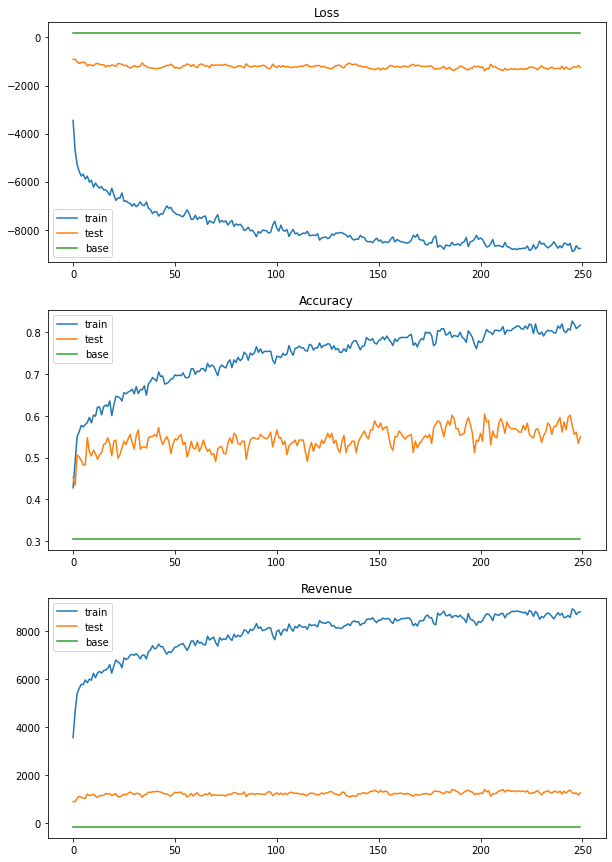

In [ ]:
model = nn_classifier(n_features=X_train.shape[1],dropout_rate=0.2,hidden_size=192,n_layers=1, use_dropout=True,use_norm=True)
baseline_clf = BaselineClassifier(y_tensor)
model.to(device=device)


loss_function = CostLoss(cost_matrix)
#loss_function = CostLossSingle(cost_matrix)
#loss_function = CostSensitiveRegularizedLoss((-1.)*cost_matrix_transformed, 2)  # (-1.)*
#loss_function = nn.CrossEntropyLoss()
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-8, factor=0.1, patience=2)

epochs = 250
train_losses, train_accs, train_revs = [], [], []
test_losses, test_accs, test_revs = [], [], []
base_losses, base_accs, base_revs = [], [], []

for update in range(epochs):
    train_loss, train_acc, train_rev = train(model, train_loader, optimizer, loss_function, device)
    train_losses.append(train_loss.detach())
    train_accs.append(train_acc.detach())
    train_revs.append(train_rev.detach())

    test_loss, test_acc, test_rev = evaluate(model, val_loader, loss_function, device)
    test_losses.append(test_loss.detach())
    test_accs.append(test_acc.detach())
    test_revs.append(test_rev.detach())

    baseline_loss, baseline_acc, baseline_rev = evaluate(baseline_clf, test_loader, loss_function, device)
    base_losses.append(baseline_loss)
    base_accs.append(baseline_acc)
    base_revs.append(baseline_rev)

    if update % 10 == 0:
        print(f'############# Epoch:{update} ###############')
        print(f'Training Loss: {train_loss:.2f}\tTraining accuracy: {train_acc:.2f}\tTraining Revenue: {train_rev:.2f}')
        print(f'Test Loss: {test_loss:.2f}\tTest accuracy: {test_acc:.2f}\tTest Revenue: {test_rev:.2f}')
    
plot_training((train_losses, train_accs, train_revs), (test_losses, test_accs, test_revs), (base_losses, base_accs, base_revs))

In [ ]:
torch.save(model,"oli_best_0.pt")

In [ ]:
evaluate(model, test_loader, loss_function, device)

(tensor(-1699.2175), tensor(0.5752), tensor(1688))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e2905743-bdaf-45dd-a896-9824e6125426' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>